In [1]:
import torch
from fastai.vision.all import *
import os

if torch.cuda.is_available():
    print("CUDA is available on this system.")
else:
    print("CUDA is NOT available on this system.")

/home/ippen/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA is available on this system.


In [2]:
# Fix Display behavior in Jupyter Notebooks for VS Code
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [3]:
def get_state_label(file_path, labels_file):
    file_name = os.path.basename(file_path)
    # Extract the state label from the filename
    with open(labels_file, "r") as f:
        labels_data = json.load(f)
    tl = labels_data[file_name]
    return tl["state"]

def get_pictogram_label(file_path, labels_file):
    file_name = os.path.basename(file_path)
    # Extract the state label from the filename
    with open(labels_file, "r") as f:
        labels_data = json.load(f)
    tl = labels_data[file_name]
    return tl["pictogram"]

In [4]:
import albumentations

class AlbumentationsTransform(DisplayedTransform):
    split_idx,order=0,2
    def __init__(self, train_aug): store_attr()
    
    def encodes(self, img: PILImage):
        aug_img = self.train_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

def get_train_aug(): return albumentations.Compose([
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            )
])

In [6]:
dataset_path = "/home/ippen/personal/traffic-light-classification/datasets/dtld/cropped_tl_combined/"
train_folder = 'train'
valid_folder = 'valid'

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock, CategoryBlock),
                   n_inp=1,
                   get_items=get_image_files,
                   get_y=[lambda file_path: get_state_label(file_path, dataset_path + '/labels.json'),lambda file_path: get_pictogram_label(file_path, dataset_path + '/labels.json')],
                   item_tfms=[Resize(224, ResizeMethod.Pad, pad_mode='zeros'), AlbumentationsTransform(get_train_aug())],
                   batch_tfms=[*aug_transforms(size=224, do_flip=False, max_rotate=3, max_warp=0.1), Contrast(max_lighting=0.25), Brightness(max_lighting=0.25)])

dls = dblock.dataloaders(dataset_path, path=dataset_path, train=train_folder, valid=valid_folder, bs=64)

In [ ]:
# dataset_path = "/home/ippen/personal/traffic-light-classification/datasets/dtld/cropped_tl_combined/valid/"

# dblock = DataBlock(blocks=(ImageBlock, CategoryBlock, CategoryBlock),
#                    n_inp=1,
#                    get_items=get_image_files,
#                    splitter=RandomSplitter(valid_pct=0.2, seed=42),
#                    get_y=[lambda file_path: get_state_label(file_path, dataset_path + '/labels.json'),lambda file_path: get_pictogram_label(file_path, dataset_path + '/labels.json')],
#                    item_tfms=[Resize(224, ResizeMethod.Pad, pad_mode='zeros'), AlbumentationsTransform(get_train_aug())],
#                    batch_tfms=[*aug_transforms(size=224, do_flip=False, max_rotate=3, max_warp=0.1), Contrast(max_lighting=0.25), Brightness(max_lighting=0.25)])

# dls = dblock.dataloaders(dataset_path, path=dataset_path, bs=64)

In [7]:
print("Train size: " + str(len(dls.train.items))+ " | Valid size: " + str(len(dls.valid.items)))

Train size: 17280 | Valid size: 4319


In [8]:
dls.vocab

(#2) [['green', 'off', 'red', 'red_yellow', 'yellow'],['arrow_left', 'arrow_right', 'arrow_straight', 'circle']]

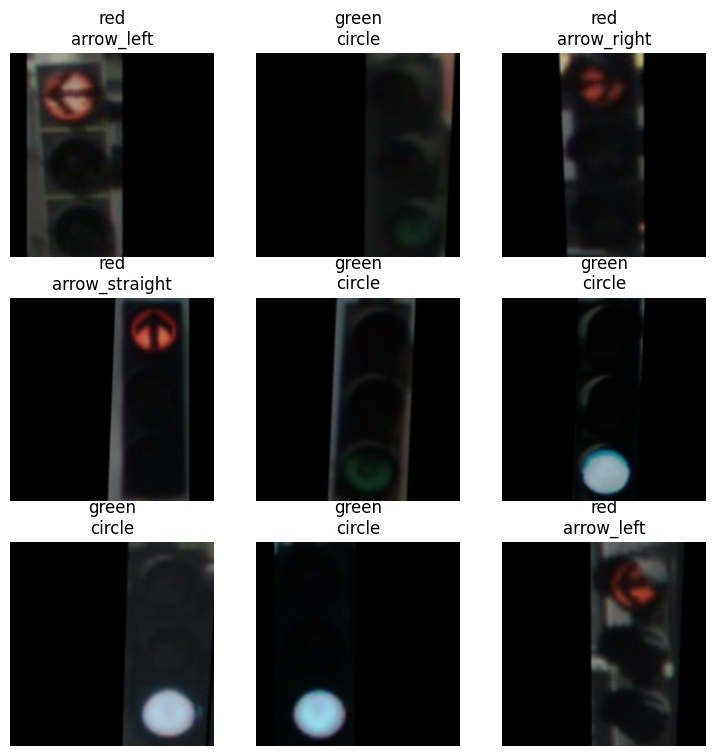

In [28]:
dls.show_batch(max_n=9)

In [29]:
def state_loss(inp,state,pictogram): return F.cross_entropy(inp[:,:5],state)
def pictogram_loss(inp,state,pictogram): return F.cross_entropy(inp[:,5:],pictogram)

In [30]:
def combine_loss(inp, state, pictogram): return 2*state_loss(inp, state, pictogram) + pictogram_loss(inp, state, pictogram)

In [31]:
def state_err(inp,state,pictogram): return error_rate(inp[:,:5],state)
def pictogram_err(inp,state,pictogram): return error_rate(inp[:,5:],pictogram)

err_metrics = (state_err, pictogram_err)

In [32]:
all_metrics = err_metrics + (state_loss, pictogram_loss)

In [33]:
# Define your own custom model class
class DualSoftmax(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, xb):
        x1, x2 = torch.split(xb, [5, 4], dim=1) # Split tensor into two parts with sizes [5, 4] along dimension 1
        x1 = F.softmax(x1, dim=1)  # Apply softmax to the first part along dimension 1
        x2 = F.softmax(x2, dim=1)  # Apply softmax to the second part along dimension 1
        x = torch.cat((x1, x2), dim=1)  # Concatenate the two parts back together along dimension 1
        return x

In [34]:
learn = vision_learner(dls, convnext_tiny, loss_func=combine_loss, metrics=all_metrics, n_out=9)

/home/ippen/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ippen/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /home/ippen/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:01<00:00, 113MB/s]  


In [35]:
learn.model[-1] = nn.Sequential(*learn.model[-1], DualSoftmax())

In [36]:
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 96 x 56 x 56   
Conv2d                                    4704       False     
LayerNorm2d                               192        True      
Conv2d                                    4800       False     
____________________________________________________________________________
                     64 x 56 x 56 x 96   
Permute                                                        
LayerNorm                                 192        True      
____________________________________________________________________________
                     64 x 56 x 56 x 384  
Linear                                    37248      False     
GELU                                                           
____________________________________________________________________________
                     64 x 56 x 56 x 96   
Linear                                    36

SuggestedLRs(valley=0.0063095735386013985)

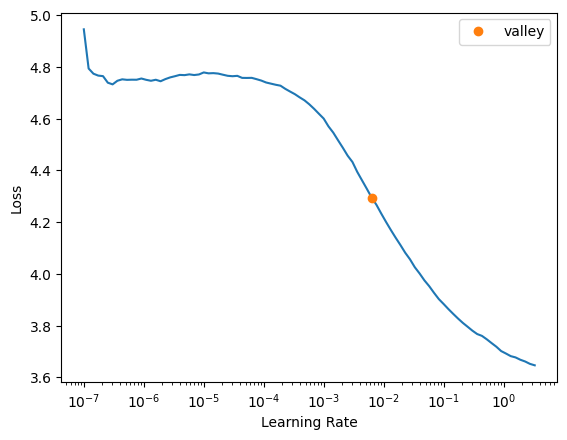

In [37]:
learn.lr_find()

In [38]:
learn.fine_tune(5, 6e-3)

epoch,train_loss,valid_loss,state_err,pictogram_err,state_loss,pictogram_loss,time
0,2.647941,2.623259,0.016671,0.037277,0.921115,0.781029,03:07
1,2.624675,2.601443,0.011808,0.025700,0.916203,0.769036,03:09
2,2.605975,2.593678,0.010419,0.018754,0.915671,0.762335,03:13
3,2.599139,2.582890,0.010651,0.008798,0.915248,0.752392,03:22
4,2.587922,2.582942,0.010882,0.008335,0.915472,0.751998,03:25


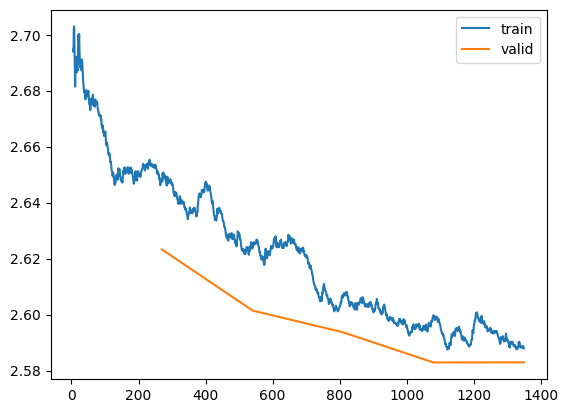

In [39]:
learn.recorder.plot_loss()

In [40]:
learn.save('tl_v5')

Path('/home/ippen/personal/traffic-light-classification/datasets/dtld/cropped_tl_combined/models/tl_v5.pth')

In [ ]:
#learn = learn.load('tl_v5')

In [41]:
def predict(img_path):
    tst_dl = learn.dls.test_dl([img_path])
    pred = learn.get_preds(dl=tst_dl)
    return pred[0][0]

def get_class(pred):
    states = ["green", "off", "red", "red_yellow", "yellow"]
    pictogram = ["arrow_left", "arrow_right", "arrow_straight", "circle"]
    pred_states = pred[:5]
    pred_pictogram = pred[5:]
    return states[pred_states.argmax()] + " " + pictogram[pred_pictogram.argmax()]

def get_probability(pred):
    pred_states = pred[:5]
    pred_pictogram = pred[5:]
    return max(pred_states), max(pred_pictogram)


tensor([9.9001e-01, 1.0479e-05, 4.2211e-06, 1.1971e-03, 8.7759e-03, 1.1713e-13,
        1.0149e-13, 2.3886e-13, 1.0000e+00])

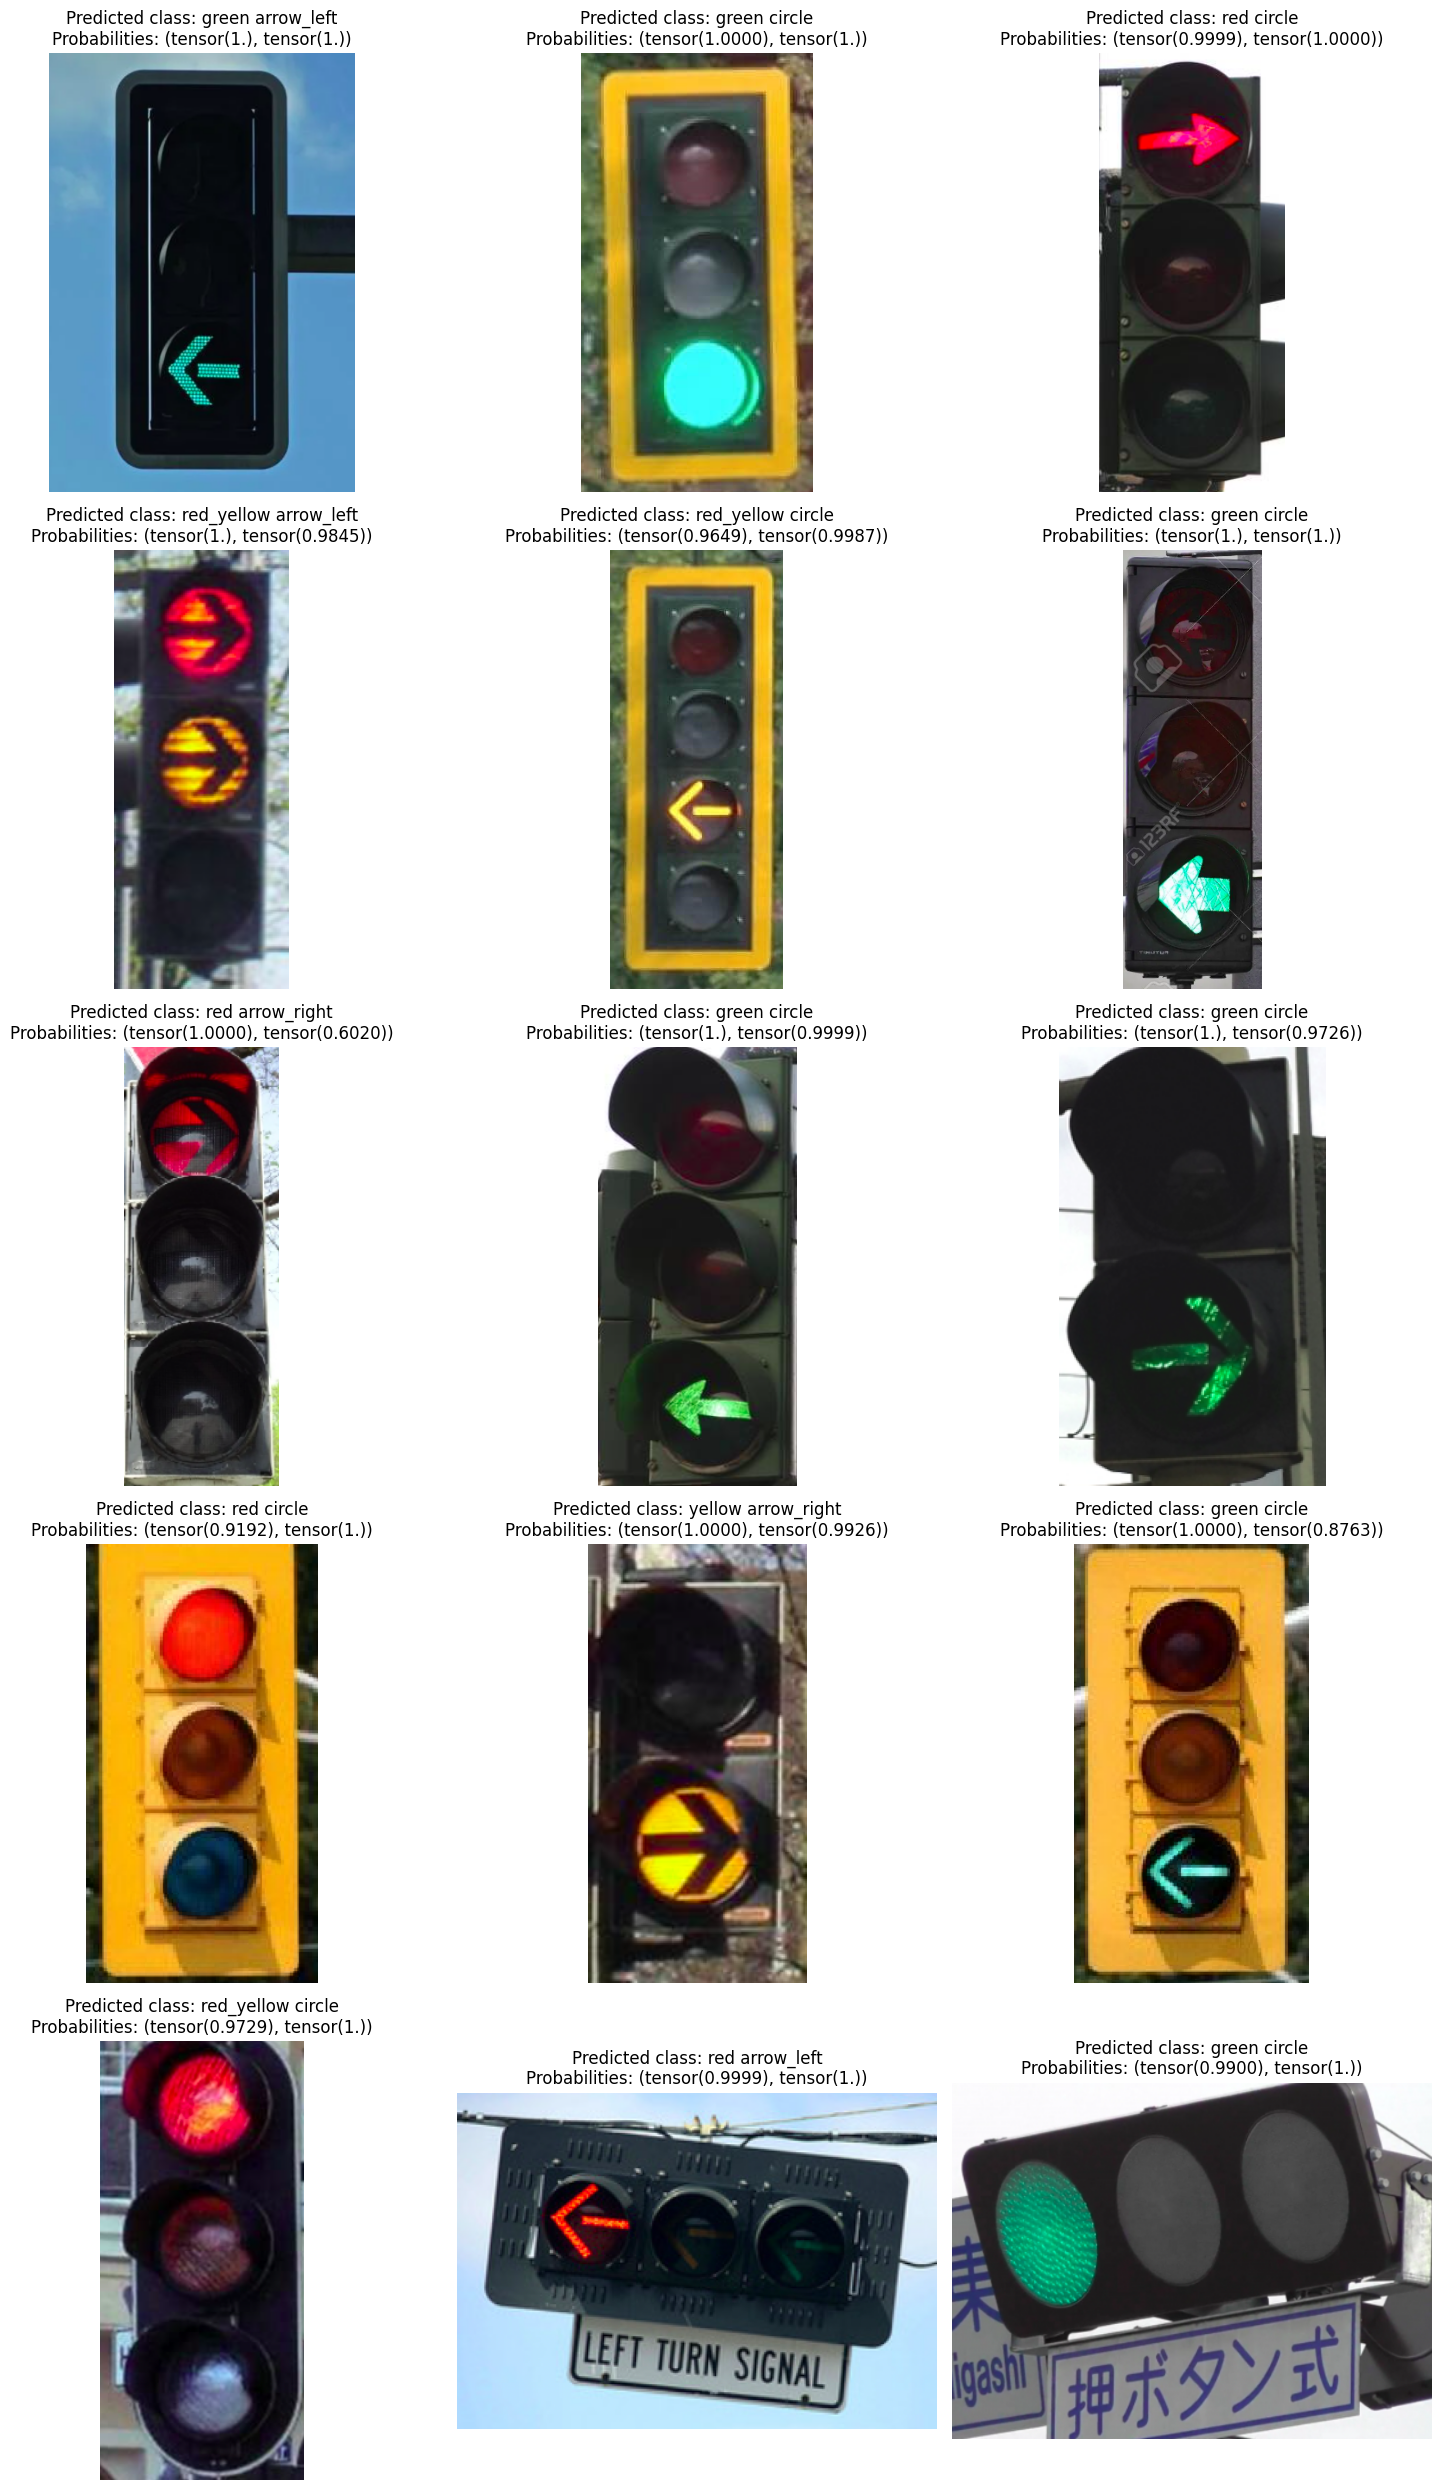

In [42]:
import matplotlib.pyplot as plt

folder_path = "/home/ippen/personal/traffic-light-classification/datasets/samples"

# Get a list of all image files in the folder
image_files = get_image_files(folder_path)

# Define the cropping transformation
crop_transform = Resize(224, ResizeMethod.Pad, pad_mode='zeros')

# Calculate the number of rows and columns for the subplot grid
num_images = len(image_files)
num_cols = 3  # Number of columns in the grid
num_rows = (num_images - 1) // num_cols + 1  # Number of rows in the grid

# Create the subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Iterate over the image files and make predictions
for idx, image_file in enumerate(image_files):
    img = PILImage.create(image_file)
    
    # Use the learner to predict the cropped image
    prediction = predict(image_file)
    display(prediction)

    # Access the predicted class and associated probabilities
    predicted_class = get_class(prediction)
    probabilities = get_probability(prediction)

    # Plot the image and display the predicted class and probabilities
    ax = axs[idx // num_cols, idx % num_cols]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Predicted class: {predicted_class}\nProbabilities: {probabilities}")

# Adjust the spacing between subplots and display the plot
plt.tight_layout()
plt.show()

In [43]:
import matplotlib.pyplot as plt

folder_path = "/home/ippen/personal/traffic-light-classification/datasets/samples"

# Get a list of all image files in the folder
image_files = get_image_files(folder_path)

# Define the cropping transformation
crop_transform = Resize(224, ResizeMethod.Pad, pad_mode='zeros')


img = PILImage.create(folder_path + "/" + "img1.png")

# Use the learner to predict the cropped image
prediction = predict(image_file)
display(prediction)

# Access the predicted class and associated probabilities
predicted_class = get_class(prediction)
probabilities = get_probability(prediction)
display(predicted_class)
display(probabilities)
display(sum(prediction[:5]))


tensor([9.9001e-01, 1.0479e-05, 4.2211e-06, 1.1971e-03, 8.7759e-03, 1.1713e-13,
        1.0149e-13, 2.3886e-13, 1.0000e+00])

'green circle'

(tensor(0.9900), tensor(1.))

tensor(1.0000)

### Results
- New convnet model seems to improve result significantly.